Necessitem una base de dades on tinguem els components que ens interessa saber si tenen interacció amb la nostre proteïna, i una base de dades que poguem entrenar el model de Machine Learning, el qual ja tingui components amb una activitat com a inhibidors. 

1. SEARCH
Primer de tot obtenim la base de dades que ens servirà per trobar possibles inhibidors. Aquesta base de dades és una llibreria de "Cysteine targeted covalent". 
Targeted covalent inhibitors have the ability to increase the potency and/or selectivity of small molecule inhibitors, by attachment of reactive functional groups designed to covalently bind to specific sites in a target.
La familia de les proteïnes GPX, tenen residus de cisteïna en els seus llocs actius, és per això, que com que hi ha molts pocs inhibidors de GPX coneguts, es selecciona aquesta llibreria per buscar possibles inhibidors. 

2. TRAIN
Larxiu train, ha de tenir 3; Smiles, Features (caracteristiques de les molecules) i l'activitat d'inhibició 


# **1. SEARCH**

Base de dades de Chemdiv de cystein targeted covalent library

In [209]:
#Read a database sdf file

from rdkit import Chem
from rdkit.Chem import SDMolSupplier
import pandas as pd

import os, requests
path = '/Users/carlafeliu/Docs/Master/TFM/github'
sdffile='Download_SDF_Covalent_Cysteine_Library_39301.sdf'
localsdffile = os.path.join(path, sdffile)
if not os.path.exists(localsdffile):
    url = 'https://www.chemdiv.com/catalog/focused-and-targeted-libraries/cysteine-targeted-covalent-library/'+sdffile
    response = requests.get(url)
    with open(localsdffile, 'wb') as f:
        f.write(response.content)
        

database = Chem.SDMolSupplier('../../../Download_SDF_Covalent_Cysteine_Library_39301.sdf')

#Repassar el codi ja que no em baixa la base de dades igual que quan ho faig manualment i per tant el codi de després no funciona.



In [189]:
#Create a dataframe
from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors
#from rdkit_forchemprop import features (tenim aquesta funció en un altre document, mirar que hi passa)

def features(mol,data):
    #Extract properties using RDKit functions
    mol_name = mol.GetProp('Name')
    smiles = Chem.MolToSmiles(mol)
    formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
    mw= Chem.rdMolDescriptors.CalcExactMolWt(mol)
    logp= Crippen.MolLogP(mol)
    num_hbd = Chem.rdMolDescriptors.CalcNumHBD(mol)
    num_hba = Chem.rdMolDescriptors.CalcNumHBA(mol)
    tpsa = Chem.rdMolDescriptors.CalcTPSA(mol)
    num_rb = Chem.rdMolDescriptors.CalcNumRotatableBonds(mol)
    

    #Append results in a data list
    data.append([smiles,mol_name,formula,mw,logp,num_hbd,num_hba,tpsa, num_rb])
    return

data = [ ]

for mol in database:
    features(mol,data)

#We have a list with information. Creation of a Dataframe:
df_chemdiv= pd.DataFrame(data,columns=['SMILES','Name','Formula','MW','logP',"H-bond donor","H-bond acceptor","TPSA","Rotatable bonds"])

**ANÀLISIS DE LES DADES**

In [190]:
#Print information about database
print(df_chemdiv.head(10))

                                              SMILES  \
0                               C(#Cc1cccs1)c1ccccc1   
1            c1ccc(C2=NC(c3ccccc3)N3C2C3c2ccccc2)cc1   
2  C(#Cc1ccc(C2Nc3ccccc3C(c3ccccc3)(c3ccccc3)O2)o...   
3                         C(#Cc1csc2ccccc12)c1ccccc1   
4  C(#Cc1cccc(-c2nc3ccccc3nc2-c2cccc(C#Cc3ccc(Sc4...   
5  C(#Cc1cccc(-c2nc3ccccc3nc2-c2cccc(C#Cc3ccc(Oc4...   
6                              C(#Cc1ccccc1)c1ccccc1   
7            C(#Cc1cc(C#Cc2ccccc2)c2nonc2c1)c1ccccc1   
8                 C(#Cc1ccc2c(c1)sc1ccccc12)c1ccccc1   
9              C(#Cc1ccc2noc(-c3ccccc3)c2c1)c1ccccc1   

                                                Name     Formula          MW  \
0                    2-(2-phenyl-1-ethynyl)thiophene      C12H8S  184.034671   
1   2,4,6-triphenyl-1,3-diazabicyclo[3.1.0]hex-3-ene    C22H18N2  310.146999   
2  4,4-diphenyl-2-[5-(2-phenylethynyl)furan-2-yl]...   C32H23NO2  453.172879   
3               3-(2-phenylethynyl)-1-benzothiophene     C16H10

In [191]:
df_chemdiv.columns

Index(['SMILES', 'Name', 'Formula', 'MW', 'logP', 'H-bond donor',
       'H-bond acceptor', 'TPSA', 'Rotatable bonds'],
      dtype='object')

In [192]:
df_chemdiv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39301 entries, 0 to 39300
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SMILES           39301 non-null  object 
 1   Name             39301 non-null  object 
 2   Formula          39301 non-null  object 
 3   MW               39301 non-null  float64
 4   logP             39301 non-null  float64
 5   H-bond donor     39301 non-null  int64  
 6   H-bond acceptor  39301 non-null  int64  
 7   TPSA             39301 non-null  float64
 8   Rotatable bonds  39301 non-null  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 2.7+ MB


Ens assegurem que a les nostres dades no hi hagi dades nul·les, ja que això podria interferir en el nostre anàlisis. 

In [193]:

df_chemdiv.isna().sum().sort_values()

SMILES             0
Name               0
Formula            0
MW                 0
logP               0
H-bond donor       0
H-bond acceptor    0
TPSA               0
Rotatable bonds    0
dtype: int64

Descripció de les dades numériques

In [195]:
df_chemdiv.describe()

,MW,logP,H-bond donor,H-bond acceptor,TPSA,Rotatable bonds
count,39301.000000,39301.000000,39301.000000,39301.000000,39301.000000,39301.000000
mean,402.267185,3.871279,0.797410,5.126791,75.722257,5.578306
std,90.915555,1.440172,0.765759,1.872088,27.249668,2.555851
min,83.073499,-3.051000,0.000000,0.000000,0.000000,0.000000
25%,344.099477,2.981400,0.000000,4.000000,58.200000,4.000000
50%,412.109293,3.937120,1.000000,5.000000,75.170000,5.000000
75%,465.131819,4.811970,1.000000,6.000000,93.200000,7.000000
max,1108.299596,14.825000,9.000000,19.000000,314.740000,29.000000


**VISUALITZACIÓ DE LES COLUMNES DEL DF**


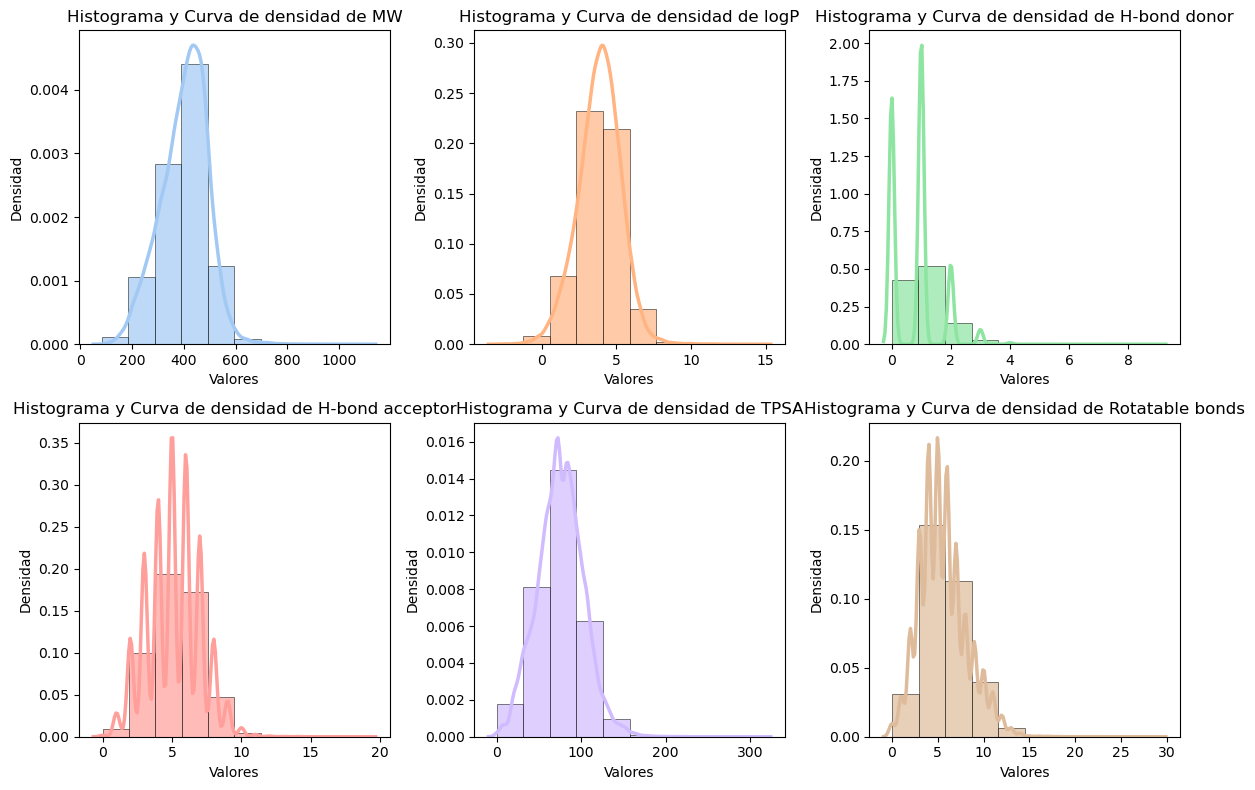

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener las columnas numéricas del dataframe
columnas_numericas = df_chemdiv.select_dtypes(include='number').columns

# Calcular el número de filas y columnas necesarias para los subplots
num_columnas = len(columnas_numericas)
num_filas = (num_columnas + 2) // 3  # División entera redondeada hacia arriba, 3 histogramas por fila

# Crear los subplots con las dimensiones adecuadas
fig, axs = plt.subplots(num_filas, 3, figsize=(12, 4 * num_filas))

# Crear una paleta de colores pastel
colores = sns.color_palette('pastel', n_colors=num_columnas)

# Crear un histograma y trazar la curva de densidad para cada columna numérica en el subplote correspondiente
for i, columna in enumerate(columnas_numericas):
    fila = i // 3
    columna_subplot = i % 3
    axs[fila, columna_subplot].hist(df_chemdiv[columna], bins=10, density=True, alpha=0.7, edgecolor='black', linewidth=0.5, color=colores[i])
    sns.kdeplot(df_chemdiv[columna], ax=axs[fila, columna_subplot], color=colores[i], linewidth=2.5)
    axs[fila, columna_subplot].set_xlabel('Valores')
    axs[fila, columna_subplot].set_ylabel('Densidad')
    axs[fila, columna_subplot].set_title(f'Histograma y Curva de densidad de {columna}')

# Ajustar los espacios entre subplots
plt.tight_layout()

# Mostrar el conjunto de subplots
plt.show()


Tenim un arxiu amb 39.301 targets, amb els smiles i els seus features. No tenim l'activitat ja que és el que volem saber aplicant Machine Learning

Ens baixem tota la base de dades de zinc20:
https://zinc20.docking.org/tranches/home/

In [32]:
import os

os.chdir('/Users/carlafeliu/Docs/Master/TFM/data')

!wget -i /Users/carlafeliu/Docs/Master/TFM/github/TFM/data/ZINC-downloader-2D-smi.uri 


--2023-07-04 17:36:34--  http://files.docking.org/2D/AA/AAAA.smi
Resolving files.docking.org (files.docking.org)... 169.230.75.3
Connecting to files.docking.org (files.docking.org)|169.230.75.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86110 (84K) [application/smil+xml]
Saving to: 'AAAA.smi'

AAAA.smi            100%[===================>]  84.09K   242KB/s    in 0.3s    

2023-07-04 17:36:35 (242 KB/s) - 'AAAA.smi' saved [86110/86110]

--2023-07-04 17:36:35--  http://files.docking.org/2D/AA/AAAB.smi
Reusing existing connection to files.docking.org:80.
HTTP request sent, awaiting response... 200 OK
Length: 154083 (150K) [application/smil+xml]
Saving to: 'AAAB.smi'

AAAB.smi            100%[===================>] 150.47K   859KB/s    in 0.2s    

2023-07-04 17:36:35 (859 KB/s) - 'AAAB.smi' saved [154083/154083]

--2023-07-04 17:36:35--  http://files.docking.org/2D/AA/AAAC.smi
Reusing existing connection to files.docking.org:80.
HTTP request sent, awaiting re

Ara agafem parts de la base de dades de zinc i la tractem per entrar-la a zinc

In [36]:
import pandas as pd

# Ruta al archivo .smi descargado
archivo_smi = '/Users/carlafeliu/Docs/Master/TFM/data/AAAA.smi'

# Leer el archivo .smi y crear un dataframe con una columna 'SMILES'
df_zinc1 = pd.read_csv(archivo_smi, sep='\t', header=None, names=['SMILES'])

# Visualizar el contenido del dataframe
print(df_zinc1.head())
len(df_zinc1)

# Guardar el dataframe en un nuevo archivo CSV
#df.to_csv('ruta/al/nuevo_archivo.csv', index=False)


                                       SMILES
0                              smiles zinc_id
1  CO[C@H]1OC[C@@H](O)[C@H](O)[C@H]1O 4371221
2           NC(=O)N[C@@H]1NC(=O)NC1=O 1843030
3                  NC(=O)CN1CCC(N)CC1 9256947
4               CNC(=O)c1n[nH]c(N)n1 19844301


2406

In [ ]:

#Create a dataframe
from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors
#from rdkit_forchemprop import features (tenim aquesta funció en un altre document, mirar que hi passa)

def features_zinc(smiles):
    mol = Chem.MolFromSmiles(smiles)
    #Extract properties using RDKit functions
    mol_name = mol.GetProp('Name')
    smiles = Chem.MolToSmiles(mol)
    formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
    mw= Chem.rdMolDescriptors.CalcExactMolWt(mol)
    logp= Crippen.MolLogP(mol)
    num_hbd = Chem.rdMolDescriptors.CalcNumHBD(mol)
    num_hba = Chem.rdMolDescriptors.CalcNumHBA(mol)
    tpsa = Chem.rdMolDescriptors.CalcTPSA(mol)
    num_rb = Chem.rdMolDescriptors.CalcNumRotatableBonds(mol)
    

    #Append results in a data list
    data.append([smiles,mol_name,formula,mw,logp,num_hbd,num_hba,tpsa, num_rb])
    return data

data = [ ]

with open(csv_file_path, "r") as file:
    lines = file.readlines()
    for line in lines:
        features_zinc(line)

#We have a list with information. Creation of a Dataframe:
df_zinc= pd.DataFrame(data,columns=['SMILES','Name','Formula','MW','logP',"H-bond donor","H-bond acceptor","TPSA","Rotatable bonds"])


# **2.TRAIN**

Fem servir la base de dades de ChEMBL, els targets de cystein proteases. 

Ens descarreguem els targets de les cysteine proteases de ChEMBL.


In [17]:
import pandas as pd

# Leer el archivo CSV y cargarlo en un DataFrame
df_targets = pd.read_csv('../data/targets_cysteine_proteases_cheml.csv', sep = ";")

# Imprimir el DataFrame
print(df_targets)

         ChEMBL ID                                      Name  \
0       CHEMBL5127             Poliovirus type 1 polyprotein   
1    CHEMBL2111357                                 Calpain 1   
2    CHEMBL3351205                               Peptidase 1   
3    CHEMBL1741213               Sentrin-specific protease 7   
4       CHEMBL3147                               Calpain 1/2   
..             ...                                       ...   
124     CHEMBL2323                               Cathepsin B   
125  CHEMBL3407323  Ubiquitin carboxyl-terminal hydrolase 10   
126  CHEMBL3407317        Ubl carboxyl-terminal hydrolase 18   
127     CHEMBL3776                                 Caspase-8   
128     CHEMBL3891                                 Calpain 1   

    UniProt Accessions             Type                    Organism  \
0               P03300   SINGLE PROTEIN  Human poliovirus 1 Mahoney   
1        P04632|P07384  PROTEIN COMPLEX                Homo sapiens   
2               P1

In [18]:
targets_id = df_targets.iloc[:, 0].tolist()
print(targets_id)

['CHEMBL5127', 'CHEMBL2111357', 'CHEMBL3351205', 'CHEMBL1741213', 'CHEMBL3147', 'CHEMBL3612', 'CHEMBL1250372', 'CHEMBL2857', 'CHEMBL5801', 'CHEMBL1741221', 'CHEMBL1795087', 'CHEMBL1293295', 'CHEMBL4072', 'CHEMBL4779', 'CHEMBL1949492', 'CHEMBL2517', 'CHEMBL2069160', 'CHEMBL1909484', 'CHEMBL3559678', 'CHEMBL1075050', 'CHEMBL2157851', 'CHEMBL1075276', 'CHEMBL5832', 'CHEMBL1075277', 'CHEMBL3430905', 'CHEMBL2223', 'CHEMBL4097', 'CHEMBL4523939', 'CHEMBL3038466', 'CHEMBL5800', 'CHEMBL2157854', 'CHEMBL2205', 'CHEMBL1697672', 'CHEMBL1293227', 'CHEMBL3774301', 'CHEMBL5169181', 'CHEMBL3937', 'CHEMBL268', 'CHEMBL3563', 'CHEMBL5991', 'CHEMBL1250373', 'CHEMBL3349', 'CHEMBL3286062', 'CHEMBL3831289', 'CHEMBL3879833', 'CHEMBL4244', 'CHEMBL4295862', 'CHEMBL3407324', 'CHEMBL2954', 'CHEMBL2226', 'CHEMBL5037', 'CHEMBL2225', 'CHEMBL2034806', 'CHEMBL4295583', 'CHEMBL4742277', 'CHEMBL2176776', 'CHEMBL3232682', 'CHEMBL2111396', 'CHEMBL1697661', 'CHEMBL1250371', 'CHEMBL4620', 'CHEMBL2111441', 'CHEMBL1075185', '

Tenim la llista dels targets ID de cysteine proteases. Ara hem de extreure tots els seus lligands amb la seva activitat. 

We are using a list of known targets, and we have to find compounds that are active on these targets. 

https://gist.github.com/avrilcoghlan/531acff5f2f5860d5fc6631f549aec43

In [19]:
import pandas as pd
import requests

#join the targets into a suitable string to fulfil the search conditions for the API
targets = ",".join(targets_id)
assay_type = 'B' #only for Binding Assays
pchembl_value = 5 #Specify the minimum threshold of the pChEMBL activity value. 
limit = 100 #limit the number of records pulled back for each url call

url_stem = "https://www.ebi.ac.uk" #This is the stem of the url
url_full_string = url_stem + "/chembl/api/data/activity.json?target_chembl_id__in={}&assay_type={}&pchembl_value__gte=5&limit={}".format(targets, assay_type, limit) #This is the full url with the specified input parameters
url_full = requests.get( url_full_string ).json() #This calls the information back from the API using the 'requests' module, and converts it to json format
url_activities = url_full['activities'] #This is a list of the results for activities

#This 'while' loop iterates over several pages of records (if required), and collates the list of results
while url_full['page_meta']['next']:
    url_full = requests.get(url_stem + url_full['page_meta']['next']).json()
    url_activities = url_activities + url_full['activities'] #Add result (as a list) to previous list of results

#Convert the list of results into a Pandas dataframe:
act_df = pd.DataFrame(url_activities)

#Print out some useful information:
print("This is the url string that calls the 'Activities' API with the initial query specification:\n{}".format(url_full_string) )
print("\nThese are the available columns for the Activities API:\n{}".format(act_df.columns))

This is the url string that calls the 'Activities' API with the initial query specification:
https://www.ebi.ac.uk/chembl/api/data/activity.json?target_chembl_id__in=CHEMBL5127,CHEMBL2111357,CHEMBL3351205,CHEMBL1741213,CHEMBL3147,CHEMBL3612,CHEMBL1250372,CHEMBL2857,CHEMBL5801,CHEMBL1741221,CHEMBL1795087,CHEMBL1293295,CHEMBL4072,CHEMBL4779,CHEMBL1949492,CHEMBL2517,CHEMBL2069160,CHEMBL1909484,CHEMBL3559678,CHEMBL1075050,CHEMBL2157851,CHEMBL1075276,CHEMBL5832,CHEMBL1075277,CHEMBL3430905,CHEMBL2223,CHEMBL4097,CHEMBL4523939,CHEMBL3038466,CHEMBL5800,CHEMBL2157854,CHEMBL2205,CHEMBL1697672,CHEMBL1293227,CHEMBL3774301,CHEMBL5169181,CHEMBL3937,CHEMBL268,CHEMBL3563,CHEMBL5991,CHEMBL1250373,CHEMBL3349,CHEMBL3286062,CHEMBL3831289,CHEMBL3879833,CHEMBL4244,CHEMBL4295862,CHEMBL3407324,CHEMBL2954,CHEMBL2226,CHEMBL5037,CHEMBL2225,CHEMBL2034806,CHEMBL4295583,CHEMBL4742277,CHEMBL2176776,CHEMBL3232682,CHEMBL2111396,CHEMBL1697661,CHEMBL1250371,CHEMBL4620,CHEMBL2111441,CHEMBL1075185,CHEMBL4510,CHEMBL4751,CHE

In [20]:
#Specify which columns to keep so that the size of the dataframe becomes more manageable:
act_df = act_df[[  'target_chembl_id','target_organism', 'target_pref_name'
                 , 'parent_molecule_chembl_id','molecule_chembl_id','molecule_pref_name'
                 , 'pchembl_value', 'standard_type','standard_relation', 'standard_value', 'standard_units'
                 , 'assay_chembl_id','document_chembl_id','src_id']]
act_df

#Aquesta taula te tots els targets amb el seu IC50
##1. Fer un analisis estadistic descriptiu. Agafar columna a columna i fer un histograma o un diagrama 
##phembl_value es el pIC50, això ens va bé per saber l'activitat. O l'standard value

,target_chembl_id,target_organism,target_pref_name,parent_molecule_chembl_id,molecule_chembl_id,molecule_pref_name,pchembl_value,standard_type,standard_relation,standard_value,standard_units,assay_chembl_id,document_chembl_id,src_id
0,CHEMBL3563,Trypanosoma cruzi,Cruzipain,CHEMBL90512,CHEMBL90512,None,7.30,IC50,=,50.0,nM,CHEMBL660279,CHEMBL1135476,1
1,CHEMBL2857,Human rhinovirus sp.,Human rhinovirus A protease,CHEMBL99102,CHEMBL99102,None,5.47,IC50,=,3400.0,nM,CHEMBL766325,CHEMBL1131042,1
2,CHEMBL2857,Human rhinovirus sp.,Human rhinovirus A protease,CHEMBL318278,CHEMBL318278,None,5.13,IC50,=,7400.0,nM,CHEMBL766325,CHEMBL1131042,1
3,CHEMBL4800,Mus musculus,Caspase-1,CHEMBL92017,CHEMBL92017,None,5.32,IC50,=,4800.0,nM,CHEMBL659308,CHEMBL1131550,1
4,CHEMBL4620,Hepatitis C virus genotype 1a (isolate 1) (HCV),Hepatitis C virus polyprotein,CHEMBL276488,CHEMBL276488,None,5.37,IC50,=,4300.0,nM,CHEMBL857692,CHEMBL1136650,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19257,CHEMBL268,Homo sapiens,Cathepsin K,CHEMBL481611,CHEMBL481611,ODANACATIB,8.77,IC50,=,1.7,nM,CHEMBL5217723,CHEMBL5214986,1
19258,CHEMBL268,Homo sapiens,Cathepsin K,CHEMBL5220424,CHEMBL5220424,None,6.01,IC50,=,974.3,nM,CHEMBL5217723,CHEMBL5214986,1
19259,CHEMBL268,Homo sapiens,Cathepsin K,CHEMBL5220960,CHEMBL5220960,None,7.21,IC50,=,61.9,nM,CHEMBL5217723,CHEMBL5214986,1
19260,CHEMBL268,Homo sapiens,Cathepsin K,CHEMBL5219348,CHEMBL5219348,None,6.63,IC50,=,235.2,nM,CHEMBL5217723,CHEMBL5214986,1


In [21]:
act_df["pchembl_value"] = act_df["pchembl_value"].astype(float)
act_df.sort_values(by="pchembl_value", ascending=False)
act_df


,target_chembl_id,target_organism,target_pref_name,parent_molecule_chembl_id,molecule_chembl_id,molecule_pref_name,pchembl_value,standard_type,standard_relation,standard_value,standard_units,assay_chembl_id,document_chembl_id,src_id
0,CHEMBL3563,Trypanosoma cruzi,Cruzipain,CHEMBL90512,CHEMBL90512,None,7.30,IC50,=,50.0,nM,CHEMBL660279,CHEMBL1135476,1
1,CHEMBL2857,Human rhinovirus sp.,Human rhinovirus A protease,CHEMBL99102,CHEMBL99102,None,5.47,IC50,=,3400.0,nM,CHEMBL766325,CHEMBL1131042,1
2,CHEMBL2857,Human rhinovirus sp.,Human rhinovirus A protease,CHEMBL318278,CHEMBL318278,None,5.13,IC50,=,7400.0,nM,CHEMBL766325,CHEMBL1131042,1
3,CHEMBL4800,Mus musculus,Caspase-1,CHEMBL92017,CHEMBL92017,None,5.32,IC50,=,4800.0,nM,CHEMBL659308,CHEMBL1131550,1
4,CHEMBL4620,Hepatitis C virus genotype 1a (isolate 1) (HCV),Hepatitis C virus polyprotein,CHEMBL276488,CHEMBL276488,None,5.37,IC50,=,4300.0,nM,CHEMBL857692,CHEMBL1136650,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19257,CHEMBL268,Homo sapiens,Cathepsin K,CHEMBL481611,CHEMBL481611,ODANACATIB,8.77,IC50,=,1.7,nM,CHEMBL5217723,CHEMBL5214986,1
19258,CHEMBL268,Homo sapiens,Cathepsin K,CHEMBL5220424,CHEMBL5220424,None,6.01,IC50,=,974.3,nM,CHEMBL5217723,CHEMBL5214986,1
19259,CHEMBL268,Homo sapiens,Cathepsin K,CHEMBL5220960,CHEMBL5220960,None,7.21,IC50,=,61.9,nM,CHEMBL5217723,CHEMBL5214986,1
19260,CHEMBL268,Homo sapiens,Cathepsin K,CHEMBL5219348,CHEMBL5219348,None,6.63,IC50,=,235.2,nM,CHEMBL5217723,CHEMBL5214986,1


array([[<Axes: title={'center': 'pchembl_value'}>]], dtype=object)

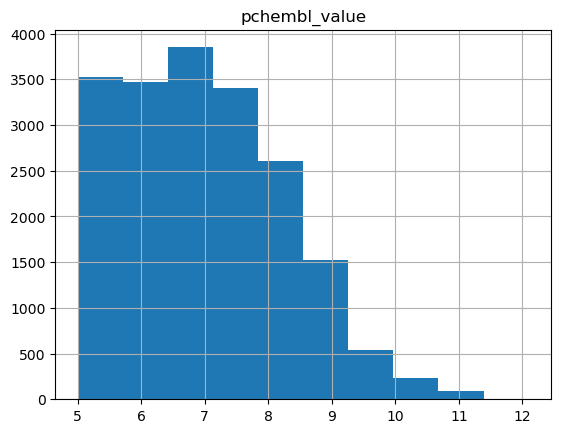

In [22]:
act_df.hist(column="pchembl_value")

#a partir de 8, sera a la -8 i son les bones. ordenar el dataframe per aquests valors primer. 

Extract the list of compounds from the previous dataframe, and call the molecule API to find their molecular properties.

In [74]:

! pip install chembl_webresource_client

In [86]:
##Obtenim una llista de tots els chembl id unics, i obtenim els seus smiles

#First find the list of compounds that are within the act_df dataframe:
cmpd_chembl_ids = list(set(act_df['molecule_chembl_id']))
print("There are {} compounds initially identified as active on the known targets. e.g.".format(len(cmpd_chembl_ids)))
#print(cmpd_chembl_ids[0:2])
#print(cmpd_chembl_ids[-2:])
len2 = len(cmpd_chembl_ids) // 80
len2 = int(len2)
start = 0

df_total = pd.DataFrame()
for i in range(len(cmpd_chembl_ids)//len2):
    variable_name = "variable_" + str(i)
    globals()[variable_name] = cmpd_chembl_ids[i*len2:(i+1)*len2]

    globals()[variable_name] = ",".join(globals()[variable_name][0:])
    limit = 1500

    url_stem = "https://www.ebi.ac.uk" #This is the stem of the url
    url_full_string = url_stem + "/chembl/api/data/molecule.json?molecule_chembl_id__in={}&limit={}".format(globals()[variable_name], limit) #This is the full url with the specified input parameters
    #print(url_full_string)
    url_full = requests.get( url_full_string, timeout = 1000 ).json() #This calls the information back from the API using the 'requests' module, and converts it to json format
    url_molecules = url_full['molecules'] #This is a list of the results for activities

    #This 'while' loop iterates over several pages of records (if required), and collates the list of results
    while url_full['page_meta']['next']:
        url_full = requests.get(url_stem + url_full['page_meta']['next']).json()
        url_molecules = url_molecules + url_full['molecules'] #Add result (as a list) to previous list of results

    #Convert the list of results into a Pandas dataframe:
    mol_df = pd.DataFrame(url_molecules)

    #Print out some useful information:
    #print("This is the url string that calls the 'Molecule' API with the specified query\n{}".format(url_full_string) )
    #print("\nThese are the available columns for the Molecule API:\n{}".format(mol_df.columns))

    #Select only relevant columns:
    mol_df = mol_df[[ 'molecule_chembl_id','molecule_structures']]
    
    mol_df['smiles'] = mol_df.loc[ mol_df['molecule_structures'].notnull(), 'molecule_structures'].apply(lambda x: x['canonical_smiles'])

    df_total = pd.concat([df_total, mol_df], ignore_index=True)

print(df_total)



There are 11140 compounds initially identified as active on the known targets. e.g.
      molecule_chembl_id                                molecule_structures  \
0             CHEMBL8563  {'canonical_smiles': 'N#CN1CCC(CNS(=O)(=O)c2cc...   
1            CHEMBL51128  {'canonical_smiles': 'N=C(N)NCCC[C@H](NC(=O)[C...   
2           CHEMBL298393  {'canonical_smiles': 'Cc1cccc(C)c1CNC(=O)[C@H]...   
3           CHEMBL302443  {'canonical_smiles': 'CC(C)CCNC(=O)[C@H](CC(C)...   
4            CHEMBL81038  {'canonical_smiles': 'CCOc1ccc(/C=C/C(=O)OC)cc...   
...                  ...                                                ...   
11115      CHEMBL5081709  {'canonical_smiles': 'COC(=O)c1ccc2c(c1)C[C@H]...   
11116      CHEMBL5184337  {'canonical_smiles': 'Cc1n[nH]c(C)c1Oc1c(O)cc(...   
11117      CHEMBL5198708  {'canonical_smiles': 'CC(=O)/C=C/[C@H](CCc1ccc...   
11118      CHEMBL5200146  {'canonical_smiles': 'CCCCCCCCCCCc1ccc(C(=O)/C...   
11119      CHEMBL5207778  {'canonical_smiles': 

#Fer un QC entre els smiles que baixo i els del rdkit. Fer els smiles amb rdkit i comparar que siguin iguals als que ja tinc
#es poden llegir els smiles a partir de rdkit, i dir que et dongui els smiles d'aquesta molecula, per tant aixo es un check

In [89]:
df_total['smiles'].isna().sum()

8

In [87]:
import pandas as pd
from rdkit import Chem

def extract_smiles(smiles_list):
    extracted_smiles = []

    for smiles in smiles_list:
        if isinstance(smiles, str) and smiles != 'nan':
            try:
                molecule = Chem.MolFromSmiles(smiles)
                if molecule is not None:
                    extracted_smiles.append(Chem.MolToSmiles(molecule))
                else:
                    extracted_smiles.append('na')
            except Exception as e:
                
                pass

    return extracted_smiles

# Obtener la columna 'smiles' como una lista de cadenas de texto
smiles_list = df_total['smiles'].astype(str).tolist()

extracted_smiles = extract_smiles(smiles_list)

# Crear un nuevo DataFrame con los SMILES extraídos
df_extracted = pd.DataFrame({'SMILES': extracted_smiles})

# Imprimir los SMILES extraídos
print(df_extracted)


                                                  SMILES
0                        N#CN1CCC(CNS(=O)(=O)c2ccccc2)C1
1      N=C(N)NCCC[C@H](NC(=O)[C@H](Cc1ccccc1)C(=O)OCc...
2      Cc1cccc(C)c1CNC(=O)[C@H]1N(C(=O)[C@@H](O)C[C@@...
3      CC(C)CCNC(=O)[C@H](CC(C)C)NC(=O)[C@H]1O[C@@H]1...
4      CCOc1ccc(/C=C/C(=O)OC)cc1CC(=O)N[C@H](C(=O)N[C...
...                                                  ...
11107  COC(=O)c1ccc2c(c1)C[C@H](NC(=O)[C@H](Cc1ccccc1...
11108  Cc1n[nH]c(C)c1Oc1c(O)cc(O)c2c(=O)cc(-c3ccc(N4C...
11109  CC(=O)/C=C/[C@H](CCc1ccccc1)NC(=O)[C@H](Cc1ccc...
11110              CCCCCCCCCCCc1ccc(C(=O)/C=C/C(=O)O)cc1
11111  CC(=O)Nc1ccc(-c2cnc(Nc3ccc(-c4ccsc4)cn3)nc2Nc2...

[11112 rows x 1 columns]


In [49]:
list_smiles_extracted = df_extracted['SMILES'].astype(str).tolist()
diferencia = list(set(smiles_list) - set(list_smiles_extracted))
print(len(diferencia))
print(diferencia)


1
['nan']


In [77]:
df_total_na = df_total['smiles'].isna().sum()
print(df_total_na)

df_extracted_na = df_extracted['SMILES'].isna().sum()
print(df_extracted_na)

#Aqui veiem que els smiles que hem extret al inici, algun no els havia agafat bé, per tant substituirem la columna de smiles del df_total per la columna de df_extracted on s'han recalculat els smiles

8
0


In [82]:
import pandas as pd

from rdkit import Chem

def verificar_moleculas(smiles_list):
    validos = []

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            validos.append("Sí")
        else:
            validos.append("NA")

    return validos

# Supongamos que tienes un dataframe llamado df con una columna 'SMILES'
smiles_list = df_extracted['SMILES'].astype(str).tolist()


resultado = verificar_moleculas(smiles_list)

# Crear un nuevo dataframe con los resultados
d_prova_smiles = pd.DataFrame({'SMILES': smiles_list, 'Válido': resultado})

# Imprimir el dataframe con la columna 'SMILES' y 'Válido'
print(d_prova_smiles)

prova_na = d_prova_smiles['Válido'].isna().sum()
print(prova_na)


                                                  SMILES Válido
0                        N#CN1CCC(CNS(=O)(=O)c2ccccc2)C1     Sí
1      N=C(N)NCCC[C@H](NC(=O)[C@H](Cc1ccccc1)C(=O)OCc...     Sí
2      Cc1cccc(C)c1CNC(=O)[C@H]1N(C(=O)[C@@H](O)C[C@@...     Sí
3      CC(C)CCNC(=O)[C@H](CC(C)C)NC(=O)[C@H]1O[C@@H]1...     Sí
4      CCOc1ccc(/C=C/C(=O)OC)cc1CC(=O)N[C@H](C(=O)N[C...     Sí
...                                                  ...    ...
11107  COC(=O)c1ccc2c(c1)C[C@H](NC(=O)[C@H](Cc1ccccc1...     Sí
11108  Cc1n[nH]c(C)c1Oc1c(O)cc(O)c2c(=O)cc(-c3ccc(N4C...     Sí
11109  CC(=O)/C=C/[C@H](CCc1ccccc1)NC(=O)[C@H](Cc1ccc...     Sí
11110              CCCCCCCCCCCc1ccc(C(=O)/C=C/C(=O)O)cc1     Sí
11111  CC(=O)Nc1ccc(-c2cnc(Nc3ccc(-c4ccsc4)cn3)nc2Nc2...     Sí

[11112 rows x 2 columns]
0


In [83]:
df_total['smiles'] = df_extracted['SMILES']
df_total_na = df_total['smiles'].isna().sum()
print(df_total_na)

8


In [85]:
df_total['smiles']
df_extracted['SMILES']


0                          N#CN1CCC(CNS(=O)(=O)c2ccccc2)C1
1        N=C(N)NCCC[C@H](NC(=O)[C@H](Cc1ccccc1)C(=O)OCc...
2        Cc1cccc(C)c1CNC(=O)[C@H]1N(C(=O)[C@@H](O)C[C@@...
3        CC(C)CCNC(=O)[C@H](CC(C)C)NC(=O)[C@H]1O[C@@H]1...
4        CCOc1ccc(/C=C/C(=O)OC)cc1CC(=O)N[C@H](C(=O)N[C...
                               ...                        
11107    COC(=O)c1ccc2c(c1)C[C@H](NC(=O)[C@H](Cc1ccccc1...
11108    Cc1n[nH]c(C)c1Oc1c(O)cc(O)c2c(=O)cc(-c3ccc(N4C...
11109    CC(=O)/C=C/[C@H](CCc1ccccc1)NC(=O)[C@H](Cc1ccc...
11110                CCCCCCCCCCCc1ccc(C(=O)/C=C/C(=O)O)cc1
11111    CC(=O)Nc1ccc(-c2cnc(Nc3ccc(-c4ccsc4)cn3)nc2Nc2...
Name: SMILES, Length: 11112, dtype: object

In [80]:
print(df_total.shape)  # Verificar el tamaño de df_total (filas, columnas)
print(df_extracted.shape)  # Verificar el tamaño de df_extracted (filas, columnas)


(11120, 3)
(11112, 1)


In [55]:
#Creem un diccionari i ho apliquem a act_df per afegir els smiles de cada molecule_chembl_id

chembl_smiles_dict = dict(zip(df_total['molecule_chembl_id'], df_total['smiles']))

act_df['Smiles'] = act_df['molecule_chembl_id'].map(chembl_smiles_dict)

act_df

,target_chembl_id,target_organism,target_pref_name,parent_molecule_chembl_id,molecule_chembl_id,molecule_pref_name,pchembl_value,standard_type,standard_relation,standard_value,standard_units,assay_chembl_id,document_chembl_id,src_id,Smiles
0,CHEMBL3563,Trypanosoma cruzi,Cruzipain,CHEMBL90512,CHEMBL90512,None,7.30,IC50,=,50.0,nM,CHEMBL660279,CHEMBL1135476,1,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)NC1CN(C(=O)[...
1,CHEMBL2857,Human rhinovirus sp.,Human rhinovirus A protease,CHEMBL99102,CHEMBL99102,None,5.47,IC50,=,3400.0,nM,CHEMBL766325,CHEMBL1131042,1,CC(C)C[C@H](C=O)NC(=O)[C@@H](CC(C)C)NC(=O)[C@H...
2,CHEMBL2857,Human rhinovirus sp.,Human rhinovirus A protease,CHEMBL318278,CHEMBL318278,None,5.13,IC50,=,7400.0,nM,CHEMBL766325,CHEMBL1131042,1,CC1=C(CCC(=O)O)c2cc3[nH]c(cc4[nH]c(cc5nc(cc1n2...
3,CHEMBL4800,Mus musculus,Caspase-1,CHEMBL92017,CHEMBL92017,None,5.32,IC50,=,4800.0,nM,CHEMBL659308,CHEMBL1131550,1,CCCC[C@H](C=O)NC(=O)[C@@H](CC(C)C)NC(=O)[C@H](...
4,CHEMBL4620,Hepatitis C virus genotype 1a (isolate 1) (HCV),Hepatitis C virus polyprotein,CHEMBL276488,CHEMBL276488,None,5.37,IC50,=,4300.0,nM,CHEMBL857692,CHEMBL1136650,1,CC(C)[C@H](NC(=O)CCc1ccccc1)C(=O)N[C@@H](C)C(=...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19257,CHEMBL268,Homo sapiens,Cathepsin K,CHEMBL481611,CHEMBL481611,ODANACATIB,8.77,IC50,=,1.7,nM,CHEMBL5217723,CHEMBL5214986,1,O=C(O)CCCC#CC#C/C=C/CCCCC#C/C=C/Br
19258,CHEMBL268,Homo sapiens,Cathepsin K,CHEMBL5220424,CHEMBL5220424,None,6.01,IC50,=,974.3,nM,CHEMBL5217723,CHEMBL5214986,1,CCCCCCCCSc1nc(Cc2cn(Cc3ccc(C(=O)OC)cc3)cn2)c[nH]1
19259,CHEMBL268,Homo sapiens,Cathepsin K,CHEMBL5220960,CHEMBL5220960,None,7.21,IC50,=,61.9,nM,CHEMBL5217723,CHEMBL5214986,1,COC(=O)CC(NC(=O)[C@@H](NC(=O)OCc1ccccc1)C(C)C)...
19260,CHEMBL268,Homo sapiens,Cathepsin K,CHEMBL5219348,CHEMBL5219348,None,6.63,IC50,=,235.2,nM,CHEMBL5217723,CHEMBL5214986,1,C=C(C)C[C@@H](C=O)NC(=O)OC(C)(C)C


In [56]:
#https://github.com/grammaloreto/Bioactivity/blob/main/Active-Inactive_types/PSMB5_ligandClassification.ipynb
#Afegim una columna al dataframe amb l'activitat (actiu o inactiu)

bioactivity_threshold = []
for i in act_df.pchembl_value:
    if float(i) >= 8:
        bioactivity_threshold.append("good")
    elif float(i) <= 6:
        bioactivity_threshold.append("insuficient")
    else:
        bioactivity_threshold.append("intermediate")


#Posem una columna que ens digui el tipo d'activitat 
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
act_df_class = pd.concat([act_df, bioactivity_class], axis=1)
act_df_class

,target_chembl_id,target_organism,target_pref_name,parent_molecule_chembl_id,molecule_chembl_id,molecule_pref_name,pchembl_value,standard_type,standard_relation,standard_value,standard_units,assay_chembl_id,document_chembl_id,src_id,Smiles,class
0,CHEMBL3563,Trypanosoma cruzi,Cruzipain,CHEMBL90512,CHEMBL90512,None,7.30,IC50,=,50.0,nM,CHEMBL660279,CHEMBL1135476,1,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)NC1CN(C(=O)[...,intermediate
1,CHEMBL2857,Human rhinovirus sp.,Human rhinovirus A protease,CHEMBL99102,CHEMBL99102,None,5.47,IC50,=,3400.0,nM,CHEMBL766325,CHEMBL1131042,1,CC(C)C[C@H](C=O)NC(=O)[C@@H](CC(C)C)NC(=O)[C@H...,insuficient
2,CHEMBL2857,Human rhinovirus sp.,Human rhinovirus A protease,CHEMBL318278,CHEMBL318278,None,5.13,IC50,=,7400.0,nM,CHEMBL766325,CHEMBL1131042,1,CC1=C(CCC(=O)O)c2cc3[nH]c(cc4[nH]c(cc5nc(cc1n2...,insuficient
3,CHEMBL4800,Mus musculus,Caspase-1,CHEMBL92017,CHEMBL92017,None,5.32,IC50,=,4800.0,nM,CHEMBL659308,CHEMBL1131550,1,CCCC[C@H](C=O)NC(=O)[C@@H](CC(C)C)NC(=O)[C@H](...,insuficient
4,CHEMBL4620,Hepatitis C virus genotype 1a (isolate 1) (HCV),Hepatitis C virus polyprotein,CHEMBL276488,CHEMBL276488,None,5.37,IC50,=,4300.0,nM,CHEMBL857692,CHEMBL1136650,1,CC(C)[C@H](NC(=O)CCc1ccccc1)C(=O)N[C@@H](C)C(=...,insuficient
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19257,CHEMBL268,Homo sapiens,Cathepsin K,CHEMBL481611,CHEMBL481611,ODANACATIB,8.77,IC50,=,1.7,nM,CHEMBL5217723,CHEMBL5214986,1,O=C(O)CCCC#CC#C/C=C/CCCCC#C/C=C/Br,good
19258,CHEMBL268,Homo sapiens,Cathepsin K,CHEMBL5220424,CHEMBL5220424,None,6.01,IC50,=,974.3,nM,CHEMBL5217723,CHEMBL5214986,1,CCCCCCCCSc1nc(Cc2cn(Cc3ccc(C(=O)OC)cc3)cn2)c[nH]1,intermediate
19259,CHEMBL268,Homo sapiens,Cathepsin K,CHEMBL5220960,CHEMBL5220960,None,7.21,IC50,=,61.9,nM,CHEMBL5217723,CHEMBL5214986,1,COC(=O)CC(NC(=O)[C@@H](NC(=O)OCc1ccccc1)C(C)C)...,intermediate
19260,CHEMBL268,Homo sapiens,Cathepsin K,CHEMBL5219348,CHEMBL5219348,None,6.63,IC50,=,235.2,nM,CHEMBL5217723,CHEMBL5214986,1,C=C(C)C[C@@H](C=O)NC(=O)OC(C)(C)C,intermediate


ANÀLISIS ESTADISTIC DEL TRAIN

In [57]:
act_df.columns

Index(['target_chembl_id', 'target_organism', 'target_pref_name',
       'parent_molecule_chembl_id', 'molecule_chembl_id', 'molecule_pref_name',
       'pchembl_value', 'standard_type', 'standard_relation', 'standard_value',
       'standard_units', 'assay_chembl_id', 'document_chembl_id', 'src_id',
       'Smiles'],
      dtype='object')

In [58]:
#Contem la quantitat de valors únics a la columna

uniq_target = act_df['target_pref_name'].nunique()

print('De', len(act_df['target_pref_name']), 'hay', uniq_target, 'targets diferentes')

De 19262 hay 70 targets diferentes


In [59]:
cont_targ = act_df['target_pref_name'].value_counts()
cont_targ

Cathepsin S                                 2510
Cathepsin K                                 2158
Cathepsin L                                 1812
Protease                                    1391
Cathepsin B                                 1276
                                            ... 
Caspase                                        1
Dipeptidyl peptidase 1                         1
Ubiquitin carboxyl-terminal hydrolase 13       1
Poliovirus type 1 polyprotein                  1
Cysteine protease ATG4A                        1
Name: target_pref_name, Length: 70, dtype: int64

In [ ]:
#POSAR-HO AMB UN DIAGRAMA DE PASTÍS

In [60]:
max_num_targ = act_df['target_pref_name'].mode()
print('La target amb més interaccions es', max_num_targ)

La target amb més interaccions es 0    Cathepsin S
Name: target_pref_name, dtype: object


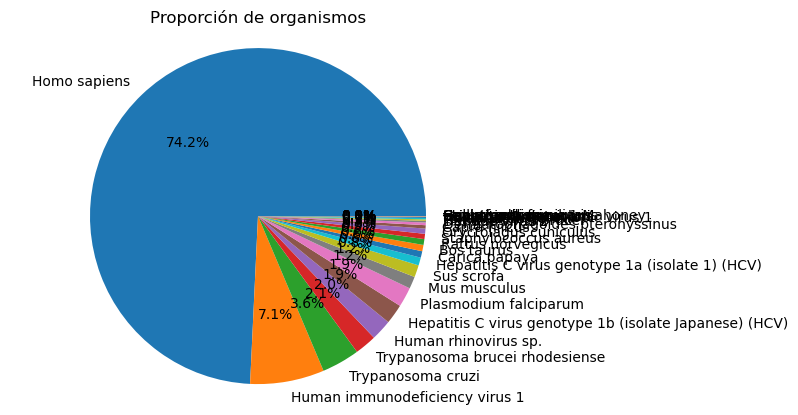

In [62]:
import matplotlib.pyplot as plt

# Obtener la frecuencia de cada organismo
frecuencia_organismos = act_df['target_organism'].value_counts()

# Crear el gráfico de pastel
plt.pie(frecuencia_organismos.values, labels=frecuencia_organismos.index, autopct='%1.1f%%')
plt.title('Proporción de organismos')
plt.axis('equal')
plt.show()


In [198]:
#Buscar si hi ha coronavirus a organismes i a targets

0                                      Trypanosoma cruzi
1                                   Human rhinovirus sp.
2                                   Human rhinovirus sp.
3                                           Mus musculus
4        Hepatitis C virus genotype 1a (isolate 1) (HCV)
                              ...                       
19257                                       Homo sapiens
19258                                       Homo sapiens
19259                                       Homo sapiens
19260                                       Homo sapiens
19261                                       Homo sapiens
Name: target_organism, Length: 19262, dtype: object

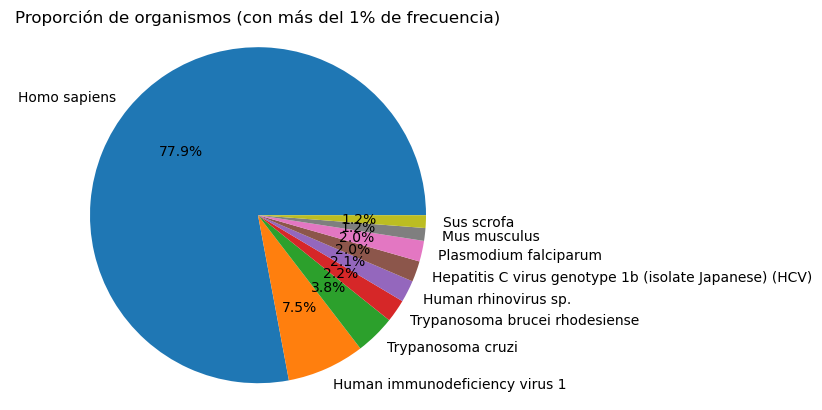

In [63]:
#Organismes que tenen mes d'un 1 %

import matplotlib.pyplot as plt

# Obtener la frecuencia de cada organismo
frecuencia_organismos = act_df['target_organism'].value_counts()

# Calcular el porcentaje de cada organismo
porcentaje_organismos = frecuencia_organismos / len(act_df) * 100

# Filtrar los organismos que tienen más del 1% de frecuencia
organismos_filtrados = porcentaje_organismos[porcentaje_organismos > 1]

# Crear el gráfico de pastel
plt.pie(organismos_filtrados.values, labels=organismos_filtrados.index, autopct='%1.1f%%')
plt.title('Proporción de organismos (con más del 1% de frecuencia)')
plt.axis('equal')
plt.show()


In [64]:
#Mirem per cada target amb quin component fa interacció
import pandas as pd

tabla_inter = act_df.groupby('target_pref_name')['molecule_chembl_id'].apply(list).reset_index()
tabla_inter.columns = ['Target', 'Component']

print(tabla_inter)

                                              Target  \
0                                          Calpain 1   
1                                        Calpain 1/2   
2                                          Calpain 2   
3                            Calpain small subunit 1   
4                                         Calpain1/2   
..                                               ...   
65           Ubiquitin carboxyl-terminal hydrolase 5   
66           Ubiquitin carboxyl-terminal hydrolase 7   
67           Ubiquitin carboxyl-terminal hydrolase 8   
68  Ubiquitin carboxyl-terminal hydrolase isozyme L1   
69  Ubiquitin carboxyl-terminal hydrolase isozyme L3   

                                            Component  
0   [CHEMBL169598, CHEMBL433914, CHEMBL169230, CHE...  
1                         [CHEMBL423112, CHEMBL32059]  
2   [CHEMBL324834, CHEMBL115426, CHEMBL116746, CHE...  
3   [CHEMBL416281, CHEMBL432121, CHEMBL301598, CHE...  
4       [CHEMBL2402203, CHEMBL4590201, CHEMBL45

In [65]:
tabla_inter

,Target,Component
0,Calpain 1,"[CHEMBL169598, CHEMBL433914, CHEMBL169230, CHE..."
1,Calpain 1/2,"[CHEMBL423112, CHEMBL32059]"
2,Calpain 2,"[CHEMBL324834, CHEMBL115426, CHEMBL116746, CHE..."
3,Calpain small subunit 1,"[CHEMBL416281, CHEMBL432121, CHEMBL301598, CHE..."
4,Calpain1/2,"[CHEMBL2402203, CHEMBL4590201, CHEMBL4520267]"
...,...,...
65,Ubiquitin carboxyl-terminal hydrolase 5,"[CHEMBL2012938, CHEMBL2012938, CHEMBL1923233]"
66,Ubiquitin carboxyl-terminal hydrolase 7,"[CHEMBL2159495, CHEMBL2159497, CHEMBL2159498, ..."
67,Ubiquitin carboxyl-terminal hydrolase 8,"[CHEMBL2398212, CHEMBL5172138, CHEMBL5196686, ..."
68,Ubiquitin carboxyl-terminal hydrolase isozyme L1,"[CHEMBL541136, CHEMBL537225, CHEMBL540117, CHE..."


<Axes: >

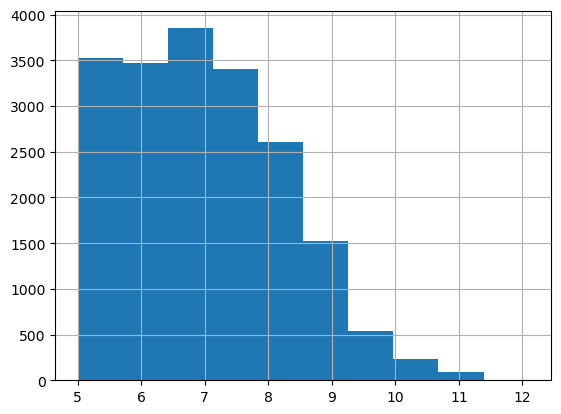

In [127]:
act_df['pchembl_value'].hist()

In [129]:
act_df.columns

Index(['target_chembl_id', 'target_organism', 'target_pref_name',
       'parent_molecule_chembl_id', 'molecule_chembl_id', 'molecule_pref_name',
       'pchembl_value', 'standard_type', 'standard_relation', 'standard_value',
       'standard_units', 'assay_chembl_id', 'document_chembl_id', 'src_id',
       'Smiles'],
      dtype='object')

In [ ]:
#FER UNA TAULA COM LA DE DALT PELS TARGETS

In [131]:
#Targets que tinguin el pvalue mes alt 
max_group = act_df.groupby('target_pref_name')['pchembl_value'].max()
max_group

target_pref_name
Calpain 1                                           8.70
Calpain 1/2                                         8.00
Calpain 2                                           8.30
Calpain small subunit 1                             8.33
Calpain1/2                                          7.02
                                                    ... 
Ubiquitin carboxyl-terminal hydrolase 5             5.52
Ubiquitin carboxyl-terminal hydrolase 7             9.80
Ubiquitin carboxyl-terminal hydrolase 8             9.55
Ubiquitin carboxyl-terminal hydrolase isozyme L1    6.64
Ubiquitin carboxyl-terminal hydrolase isozyme L3    7.30
Name: pchembl_value, Length: 70, dtype: float64

CONSTRUIR EL TRAIN PER CHEMPROP AMB EL QUE TENIM
Necessitem:
- Smiles
- Features
- Activitat

**RDKIT:**

Features RDKIT:
*Molecular weight: 
*LogP
*Number hydrogen acceptors
*Number hydrogen donors
*Rotatable bonds
*TPSA
*Number of rings
*Number of heavy atoms
*Fraction CSP3
*Balaban J Index








In [66]:
df_train = act_df.loc[:, ['Smiles', 'target_chembl_id', 'target_pref_name', 'molecule_chembl_id', 'pchembl_value']]
df_train

,Smiles,target_chembl_id,target_pref_name,molecule_chembl_id,pchembl_value
0,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)NC1CN(C(=O)[...,CHEMBL3563,Cruzipain,CHEMBL90512,7.30
1,CC(C)C[C@H](C=O)NC(=O)[C@@H](CC(C)C)NC(=O)[C@H...,CHEMBL2857,Human rhinovirus A protease,CHEMBL99102,5.47
2,CC1=C(CCC(=O)O)c2cc3[nH]c(cc4[nH]c(cc5nc(cc1n2...,CHEMBL2857,Human rhinovirus A protease,CHEMBL318278,5.13
3,CCCC[C@H](C=O)NC(=O)[C@@H](CC(C)C)NC(=O)[C@H](...,CHEMBL4800,Caspase-1,CHEMBL92017,5.32
4,CC(C)[C@H](NC(=O)CCc1ccccc1)C(=O)N[C@@H](C)C(=...,CHEMBL4620,Hepatitis C virus polyprotein,CHEMBL276488,5.37
...,...,...,...,...,...
19257,O=C(O)CCCC#CC#C/C=C/CCCCC#C/C=C/Br,CHEMBL268,Cathepsin K,CHEMBL481611,8.77
19258,CCCCCCCCSc1nc(Cc2cn(Cc3ccc(C(=O)OC)cc3)cn2)c[nH]1,CHEMBL268,Cathepsin K,CHEMBL5220424,6.01
19259,COC(=O)CC(NC(=O)[C@@H](NC(=O)OCc1ccccc1)C(C)C)...,CHEMBL268,Cathepsin K,CHEMBL5220960,7.21
19260,C=C(C)C[C@@H](C=O)NC(=O)OC(C)(C)C,CHEMBL268,Cathepsin K,CHEMBL5219348,6.63


In [68]:
from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors

#Calculem els features per els components que tenim en el dataframe de train

def calc_feat(df,columna):
    data_c = []
    for smile in df[columna]:
        if pd.notna(smile): #saltem els que te smile na
            mol = Chem.MolFromSmiles(smile)
            if mol is not None:
                mw = Descriptors.MolWt(mol)
                logp = Descriptors.MolLogP(mol)
                hba_num = Descriptors.NumHAcceptors(mol)
                hbd_num = Descriptors.NumHDonors(mol)
                rotb_num = Descriptors.NumRotatableBonds(mol)
                tpsa = Chem.rdMolDescriptors.CalcTPSA(mol)
                ring_num = Chem.Descriptors.RingCount(mol)
                ha_num = Chem.Descriptors.HeavyAtomCount(mol)
                csp3 = Chem.Descriptors.FractionCSP3(mol)
                bji = Chem.Descriptors.BalabanJ(mol)

                data_c.append([mw,logp,hbd_num,hba_num,rotb_num,tpsa,ring_num,ha_num,csp3,bji])
    return data_c


data_c = calc_feat(df_train, 'Smiles')
data_c

df_result_feat= pd.DataFrame(data_c,columns=['MW','logP',"H-bond donor","H-bond acceptor","Rotatable bonds", "TPSA", "Ring counts", "Heavy atoms counts", "Fraction CSP3", "Balaban J Index"])
#df_resultados = calc_feat(df_train, df_train['Smiles'], data_c)
#df= pd.DataFrame(data,columns=['SMILES','Name','Formula','MW','logP',"H-bond donor","H-bond acceptor","TPSA","Rotatable bonds"])

In [ ]:
#intentar treure els features a partir del chemblID i aviam que passa (QC)

In [69]:
df_train_chemp = pd.concat([df_train, df_result_feat], axis=1)
#df_train_chemp

#La columna de smiles es l'smile del component, per tant els features també

#Posem la columna d'activitat al final

activity = df_train_chemp.pop('pchembl_value')

df_train_chemp['pchembl_value'] = activity

df_train_chemp

,Smiles,target_chembl_id,target_pref_name,molecule_chembl_id,MW,logP,H-bond donor,H-bond acceptor,Rotatable bonds,TPSA,Ring counts,Heavy atoms counts,Fraction CSP3,Balaban J Index,pchembl_value
0,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)NC1CN(C(=O)[...,CHEMBL3563,Cruzipain,CHEMBL90512,594.709,3.56470,3.0,7.0,13.0,143.14,3.0,43.0,0.468750,1.565440,7.30
1,CC(C)C[C@H](C=O)NC(=O)[C@@H](CC(C)C)NC(=O)[C@H...,CHEMBL2857,Human rhinovirus A protease,CHEMBL99102,490.645,2.67110,4.0,6.0,16.0,139.62,1.0,35.0,0.615385,2.846043,5.47
2,CC1=C(CCC(=O)O)c2cc3[nH]c(cc4[nH]c(cc5nc(cc1n2...,CHEMBL2857,Human rhinovirus A protease,CHEMBL318278,894.934,7.57794,4.0,12.0,18.0,237.16,9.0,66.0,0.320000,1.309277,5.13
3,CCCC[C@H](C=O)NC(=O)[C@@H](CC(C)C)NC(=O)[C@H](...,CHEMBL4800,Caspase-1,CHEMBL92017,383.533,1.94200,3.0,4.0,13.0,104.37,0.0,27.0,0.800000,5.135403,5.32
4,CC(C)[C@H](NC(=O)CCc1ccccc1)C(=O)N[C@@H](C)C(=...,CHEMBL4620,Hepatitis C virus polyprotein,CHEMBL276488,615.749,1.84090,4.0,7.0,18.0,175.81,2.0,43.0,0.451613,1.935685,5.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19257,O=C(O)CCCC#CC#C/C=C/CCCCC#C/C=C/Br,CHEMBL268,Cathepsin K,CHEMBL481611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.77
19258,CCCCCCCCSc1nc(Cc2cn(Cc3ccc(C(=O)OC)cc3)cn2)c[nH]1,CHEMBL268,Cathepsin K,CHEMBL5220424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.01
19259,COC(=O)CC(NC(=O)[C@@H](NC(=O)OCc1ccccc1)C(C)C)...,CHEMBL268,Cathepsin K,CHEMBL5220960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.21
19260,C=C(C)C[C@@H](C=O)NC(=O)OC(C)(C)C,CHEMBL268,Cathepsin K,CHEMBL5219348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.63


In [91]:
df_train_chemp['Smiles'].isna().sum()

52

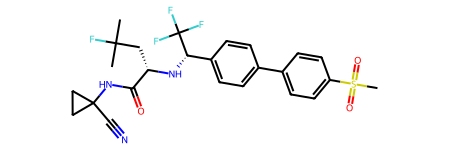

In [199]:
#El que conté mol
eu = df_train['Smiles'].iloc[19257]
mol = Chem.MolFromSmiles(eu)
mol

In [ ]:
import pandas as pd

df_final_train_ch = df_train_chemp.loc[:, ['Smiles', 'MW', 'logP', , 'H-bond donor', 'H-bond acceptor', 'Rotatable bonds', 'TPSA', 'Ring Counts', 'Heavy atoms counts', 'Fraction CSP3', 'Balaban J Index', 'pchembl_value']]
df_train

S'ha de crear un arxiu amb el dataframe que hem creat anteriorment per poder introduir a chemprop


Ara hem de fer prova amb chemprop. 
1. Amb el document que tenim
2. AMb un altre df , smiles + activitat. el chemprop li has de dir que vols que calculi les features

## **AIXO DE MOMENT RES**

## Filter the compound list based on relevant information

El nostre arxiu de compounds era massa gran, per tant fem un loop per executar el codi mica en mica, i al final ho guardem tot en un data frame que es diu: df_total

Això de moment no ho fem servir

In [ ]:
#First find the list of compounds that are within the act_df dataframe:
cmpd_chembl_ids = list(set(act_df['molecule_chembl_id']))
print("There are {} compounds initially identified as active on the known targets. e.g.".format(len(cmpd_chembl_ids)))
print(cmpd_chembl_ids[0:2])
print(cmpd_chembl_ids[-2:])
len2 = len(cmpd_chembl_ids) // 80
len2 = int(len2)
start = 0

df_total = pd.DataFrame()

for i in range(len(cmpd_chembl_ids)//len2):
    variable_name = "variable_" + str(i)
    globals()[variable_name] = cmpd_chembl_ids[i*len2:(i+1)*len2]

    globals()[variable_name] = ",".join(globals()[variable_name][0:])
    limit = 1500

    #Set up the call to the ChEMBL 'molecule' API
    #Remember that there is a limit to the number of records returned in any one API call (default is 20 records, maximum is 1000 records)
    #So need to iterate over several pages of records to gather all relevant information together!

    url_stem = "https://www.ebi.ac.uk" #This is the stem of the url
    url_full_string = url_stem + "/chembl/api/data/molecule.json?molecule_chembl_id__in={}&limit={}".format(globals()[variable_name], limit) #This is the full url with the specified input parameters
    #print(url_full_string)
    url_full = requests.get( url_full_string, timeout = 1000 ).json() #This calls the information back from the API using the 'requests' module, and converts it to json format
    url_molecules = url_full['molecules'] #This is a list of the results for activities

    #This 'while' loop iterates over several pages of records (if required), and collates the list of results
    while url_full['page_meta']['next']:
        url_full = requests.get(url_stem + url_full['page_meta']['next']).json()
        url_molecules = url_molecules + url_full['molecules'] #Add result (as a list) to previous list of results

    #Convert the list of results into a Pandas dataframe:
    mol_df = pd.DataFrame(url_molecules)

    #Print out some useful information:
    #print("This is the url string that calls the 'Molecule' API with the specified query\n{}".format(url_full_string) )
    #print("\nThese are the available columns for the Molecule API:\n{}".format(mol_df.columns))

    #Select only relevant columns:
    mol_df = mol_df[[ 'molecule_chembl_id','pref_name', 'molecule_hierarchy'
                 , 'molecule_properties', 'max_phase']]

    #print(mol_df)
    #And convert cells containing a dictionary to individual columns in the dataframe so that is it easier to filter!

    # Molecule hierarchy: 
    mol_df['parent_chembl_id'] = mol_df['molecule_hierarchy'].apply(lambda x: x['parent_chembl_id'])
    #print(mol_df)

    mol_df['alogp'] = mol_df.loc[ mol_df['molecule_properties'].notnull(), 'molecule_properties'].apply(lambda x: x['alogp'])
    mol_df['hba'] = mol_df.loc[ mol_df['molecule_properties'].notnull(), 'molecule_properties'].apply(lambda x: x['hba'])
    mol_df['hbd'] = mol_df.loc[ mol_df['molecule_properties'].notnull(), 'molecule_properties'].apply(lambda x: x['hbd'])
    mol_df['mw_freebase'] = mol_df.loc[ mol_df['molecule_properties'].notnull(), 'molecule_properties'].apply(lambda x: x['mw_freebase']) #This is the mwt of the parent compound
    mol_df['full_mwt'] = mol_df.loc[ mol_df['molecule_properties'].notnull(), 'molecule_properties'].apply(lambda x: x['full_mwt']) #This is the mwt of the full compound including any salt
    mol_df['num_ro5_violations'] = mol_df.loc[ mol_df['molecule_properties'].notnull(), 'molecule_properties'].apply(lambda x: x['num_ro5_violations'])
    mol_df['psa'] = mol_df.loc[ mol_df['molecule_properties'].notnull(), 'molecule_properties'].apply(lambda x: x['psa'])
    mol_df['heavy_atoms'] = mol_df.loc[ mol_df['molecule_properties'].notnull(), 'molecule_properties'].apply(lambda x: x['heavy_atoms'])
    #mol_df
    res = mol_df[ mol_df['max_phase'] == 4 ]
    res.head()

    # Agregar los resultados al dataframe acumulativo
    df_total = pd.concat([df_total, mol_df], ignore_index=True)
    
print(df_total)

    

There are 11140 compounds initially identified as active on the known targets. e.g.
['CHEMBL196990', 'CHEMBL3667402']
['CHEMBL4567870', 'CHEMBL1359190']
      molecule_chembl_id pref_name  \
0           CHEMBL268737      None   
1            CHEMBL22597      None   
2            CHEMBL30957      None   
3            CHEMBL30411      None   
4            CHEMBL48837      None   
...                  ...       ...   
11115      CHEMBL4859374      None   
11116      CHEMBL5077948      None   
11117      CHEMBL5085283      None   
11118      CHEMBL5174815      None   
11119      CHEMBL5197170      None   

                                      molecule_hierarchy  \
0      {'active_chembl_id': 'CHEMBL268737', 'molecule...   
1      {'active_chembl_id': 'CHEMBL22597', 'molecule_...   
2      {'active_chembl_id': 'CHEMBL30957', 'molecule_...   
3      {'active_chembl_id': 'CHEMBL30411', 'molecule_...   
4      {'active_chembl_id': 'CHEMBL48837', 'molecule_...   
...                           

In [47]:

df_total


,molecule_chembl_id,pref_name,molecule_hierarchy,molecule_properties,max_phase,parent_chembl_id,alogp,hba,hbd,mw_freebase,full_mwt,num_ro5_violations,psa,heavy_atoms
0,CHEMBL268737,None,"{'active_chembl_id': 'CHEMBL268737', 'molecule...","{'alogp': '2.05', 'aromatic_rings': 3, 'cx_log...",None,CHEMBL268737,2.05,7.0,2.0,591.69,591.69,1.0,131.11,42.0
1,CHEMBL22597,None,"{'active_chembl_id': 'CHEMBL22597', 'molecule_...","{'alogp': '2.02', 'aromatic_rings': 2, 'cx_log...",None,CHEMBL22597,2.02,5.0,3.0,430.43,430.43,0.0,121.80,31.0
2,CHEMBL30957,None,"{'active_chembl_id': 'CHEMBL30957', 'molecule_...","{'alogp': '2.28', 'aromatic_rings': 2, 'cx_log...",None,CHEMBL30957,2.28,5.0,3.0,439.51,439.51,0.0,105.76,32.0
3,CHEMBL30411,None,"{'active_chembl_id': 'CHEMBL30411', 'molecule_...","{'alogp': '2.54', 'aromatic_rings': 2, 'cx_log...",None,CHEMBL30411,2.54,5.0,2.0,357.36,357.36,0.0,101.93,26.0
4,CHEMBL48837,None,"{'active_chembl_id': 'CHEMBL48837', 'molecule_...","{'alogp': '4.20', 'aromatic_rings': 3, 'cx_log...",None,CHEMBL48837,4.20,6.0,2.0,530.62,530.62,1.0,110.80,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11115,CHEMBL4859374,None,"{'active_chembl_id': 'CHEMBL4859374', 'molecul...","{'alogp': '4.70', 'aromatic_rings': 3, 'cx_log...",None,CHEMBL4859374,4.70,7.0,2.0,491.91,491.91,0.0,86.28,34.0
11116,CHEMBL5077948,None,"{'active_chembl_id': 'CHEMBL5077948', 'molecul...","{'alogp': '2.41', 'aromatic_rings': 2, 'cx_log...",None,CHEMBL5077948,2.41,7.0,1.0,552.02,552.02,1.0,97.41,37.0
11117,CHEMBL5085283,None,"{'active_chembl_id': 'CHEMBL5085283', 'molecul...","{'alogp': '0.94', 'aromatic_rings': 2, 'cx_log...",None,CHEMBL5085283,0.94,7.0,2.0,483.55,483.55,0.0,108.41,34.0
11118,CHEMBL5174815,None,"{'active_chembl_id': 'CHEMBL5174815', 'molecul...","{'alogp': '5.48', 'aromatic_rings': 4, 'cx_log...",None,CHEMBL5174815,5.48,4.0,2.0,552.70,552.70,2.0,92.34,40.0


In [48]:
df_total.columns

Index(['molecule_chembl_id', 'pref_name', 'molecule_hierarchy',
       'molecule_properties', 'max_phase', 'parent_chembl_id', 'alogp', 'hba',
       'hbd', 'mw_freebase', 'full_mwt', 'num_ro5_violations', 'psa',
       'heavy_atoms'],
      dtype='object')